In [1]:
from dblinea import DBBase
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os
from astroquery.vizier import Vizier
import astropy.coordinates as coord
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import ascii
from scipy.stats import gaussian_kde
from matplotlib.ticker import FormatStrFormatter

In [770]:
import warnings
warnings.filterwarnings("ignore")

## Selecting SDSS/BOSS cross-matched

In [2]:
sdss = pd.read_csv('/home/iago.dias/SDSS-BOSS.csv')

In [3]:
sdss = sdss[sdss['f_zsp']<40]

In [4]:
sdss = sdss[['RA_ICRS','DE_ICRS','zsp']]
sdss.columns = ['ra','dec','z']

In [5]:
sdss['survey']='SDSS/BOSS'

In [6]:
sdss = sdss[(sdss['ra']>35) & (sdss['ra']<37.5) & (sdss['dec']<-3.5)& (sdss['dec']>-5.7)] 

In [7]:
sdss

,ra,dec,z,survey
229,37.255031,-5.688772,0.95767,SDSS/BOSS
237,37.290464,-5.670331,0.33875,SDSS/BOSS
238,37.437218,-5.675375,0.48237,SDSS/BOSS
239,37.413628,-5.640567,0.08701,SDSS/BOSS
240,37.390754,-5.624758,0.98790,SDSS/BOSS
...,...,...,...,...
1712,35.285733,-3.539826,0.57483,SDSS/BOSS
1713,35.278646,-3.524045,0.55166,SDSS/BOSS
1715,35.510182,-3.567297,0.43385,SDSS/BOSS
1724,35.814534,-3.506449,0.61090,SDSS/BOSS


In [8]:
xlim = [35, 37.6]
ylim = [-5.7, -3.5]
l = 750000
query = f"SELECT alphawin_j2000, deltawin_j2000,ra,dec, extended_class_coadd, mag_auto_g, mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y, magerr_auto_g, magerr_auto_r, magerr_auto_i, magerr_auto_z, magerr_auto_y FROM des_dr2.coadd_objects WHERE q3c_poly_query(ra, dec, ARRAY[{xlim[0]}, {ylim[1]}, {xlim[0]}, {ylim[0]}, {xlim[1]}, {ylim[0]}, {xlim[1]}, {ylim[1]}]) AND extended_class_coadd >= 2 AND mag_auto_g<90 AND mag_auto_r<90 AND mag_auto_i<90 AND mag_auto_z<90 AND mag_auto_y<90 limit {l}"





In [9]:
db = DBBase()

In [10]:
%%time
df_phot = db.fetchall_df(query)
df_phot

CPU times: user 6.49 s, sys: 1.25 s, total: 7.74 s
Wall time: 2min 41s


,alphawin_j2000,deltawin_j2000,ra,dec,extended_class_coadd,mag_auto_g,mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y,magerr_auto_g,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y
0,35.007487,-5.699908,35.007487,-5.699908,2,26.686527,25.948038,25.431511,24.791912,23.509333,0.753584,0.458936,0.480496,0.543438,0.487275
1,35.007206,-5.698918,35.007206,-5.698918,2,27.243288,27.874516,25.645271,24.257034,23.200809,1.591974,3.312021,0.700980,0.406555,0.448916
2,35.014199,-5.699963,35.014199,-5.699963,3,24.688322,22.845715,21.725687,21.233761,20.832272,0.302786,0.071784,0.041562,0.056253,0.121213
3,35.005710,-5.697600,35.005710,-5.697600,2,25.376404,25.182186,24.695261,23.899033,23.668526,0.403480,0.419228,0.461975,0.438974,1.204582
4,35.005364,-5.696071,35.005364,-5.696071,2,24.941610,24.038229,23.319973,22.473572,21.917591,0.474679,0.282959,0.246103,0.229174,0.446646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478057,37.596972,-3.503949,37.596972,-3.503949,2,28.127264,25.018057,24.558380,23.124821,24.091845,3.914046,0.292783,0.382538,0.181597,1.397011
478058,37.590642,-3.501616,37.590642,-3.501616,2,25.212179,24.898882,25.434877,27.766800,24.401665,0.201906,0.196547,0.658452,10.089209,1.204927
478059,37.596333,-3.501956,37.596333,-3.501956,2,24.835213,24.393511,24.042221,24.025785,22.998522,0.222992,0.185367,0.280440,0.491143,0.603241
478060,37.599093,-3.512776,37.599093,-3.512776,3,22.987028,21.334810,20.564507,20.187857,20.096292,0.059058,0.017016,0.016643,0.020837,0.060350


In [11]:
%%time
coords1 = SkyCoord(ra=df_phot['ra'], dec=df_phot['dec'], unit=(u.deg, u.deg))
coords2 = SkyCoord(ra=sdss['ra'], dec=sdss['dec'], unit=(u.deg, u.deg))


CPU times: user 1min 6s, sys: 486 ms, total: 1min 6s
Wall time: 1min 6s


In [12]:
# Defina um raio de busca (por exemplo, 1 arcsec)
radius = 1 * u.arcsec

# Realize o cruzamento entre os catálogos
# use o método search_around_sky para encontrar objetos coincidentes em um raio
idx1, idx2, d2d, _ = coords1.search_around_sky(coords2, radius)

# idx1 e idx2 contêm os índices dos objetos correspondentes em catalog1 e catalog2
# d2d contém as distâncias angulares entre os objetos correspondentes em arcsec

# Agora você pode usar os índices para acessar os objetos correspondentes em seus catálogos originais
sdss_matched = df_phot.iloc[idx2]
zspec = sdss.iloc[idx1]['z'].values

sdss_matched['z'] = zspec



/tmp/ipykernel_13157/4229036883.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdss_matched['z'] = zspec


In [13]:
sdss_matched['survey']='SDSS/BOSS'

/tmp/ipykernel_13157/249163995.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdss_matched['survey']='SDSS/BOSS'


In [14]:
sdss_matched

,alphawin_j2000,deltawin_j2000,ra,dec,extended_class_coadd,mag_auto_g,mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y,magerr_auto_g,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y,z,survey
347081,37.255029,-5.688740,37.255029,-5.688740,3,22.149763,22.024118,21.480795,21.265371,21.381197,0.024116,0.029117,0.031689,0.050407,0.187459,0.95767,SDSS/BOSS
357302,37.290511,-5.670288,37.290511,-5.670288,3,20.368042,18.719124,18.175367,17.871948,17.735844,0.012804,0.003618,0.003889,0.005722,0.016731,0.33875,SDSS/BOSS
347462,37.437240,-5.675342,37.437240,-5.675342,3,21.848080,20.027540,19.321104,18.867994,18.668270,0.040691,0.009449,0.009188,0.012096,0.032901,0.48237,SDSS/BOSS
359507,37.413654,-5.640530,37.413654,-5.640530,3,17.227966,16.316692,15.940803,15.656432,15.529766,0.001460,0.000828,0.001053,0.001519,0.004480,0.08701,SDSS/BOSS
359588,37.390743,-5.624734,37.390743,-5.624734,3,22.256493,21.933615,21.404972,21.240953,21.167528,0.024575,0.023864,0.026510,0.043123,0.133044,0.98790,SDSS/BOSS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260310,35.285689,-3.539843,35.285689,-3.539843,3,21.766348,20.213488,19.387247,18.973791,18.866899,0.029791,0.010394,0.008991,0.011265,0.030233,0.57483,SDSS/BOSS
260371,35.278654,-3.524113,35.278654,-3.524113,3,21.742535,19.765615,18.933088,18.531687,18.472466,0.032502,0.007749,0.006445,0.007658,0.021189,0.55166,SDSS/BOSS
261943,35.510185,-3.567325,35.510185,-3.567325,3,21.693323,20.039982,19.464895,19.154772,19.030590,0.029494,0.009056,0.009120,0.012940,0.030145,0.43385,SDSS/BOSS
338158,35.814469,-3.506495,35.814469,-3.506495,3,22.180002,20.395002,19.347071,18.906082,18.829689,0.057846,0.016076,0.010689,0.012002,0.029610,0.61090,SDSS/BOSS


## Selecting 2dFRGS cross-matched

In [15]:
two_d = pd.read_csv('/home/iago.dias/2dfgrs.csv')

In [16]:
two_d = two_d[two_d['q_z']>=3]

In [17]:
#two_d = two_d[two_d['SNR']>=10] tirar???

In [18]:
two_d = two_d[['RAJ2000','DEJ2000','z']]
two_d.columns=['ra','dec','z']

In [19]:
two_d['survey']='2dFRGS'

In [20]:
two_d = two_d[(two_d['ra']>51.5) & (two_d['ra']<53.9) & (two_d['dec']<-26.9)& (two_d['dec']>-29.2)] 

In [21]:
two_d

,ra,dec,z,survey
890,52.400792,-29.166583,0.2360,2dFRGS
891,52.488417,-29.188250,0.0715,2dFRGS
892,52.522583,-29.162500,0.2830,2dFRGS
893,52.489458,-29.095500,0.1101,2dFRGS
894,52.453292,-29.074472,0.0712,2dFRGS
...,...,...,...,...
2736,51.899750,-26.946694,0.1489,2dFRGS
2737,51.736708,-26.951944,0.1438,2dFRGS
2738,51.721333,-26.928528,0.1433,2dFRGS
2740,51.819292,-26.903333,0.2023,2dFRGS


In [22]:
xlim = [51.5, 53.9]
ylim = [-29.2, -26.9]
l = 750000
query = f"SELECT alphawin_j2000, deltawin_j2000,ra,dec, extended_class_coadd, mag_auto_g, mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y, magerr_auto_g, magerr_auto_r, magerr_auto_i, magerr_auto_z, magerr_auto_y FROM des_dr2.coadd_objects WHERE q3c_poly_query(ra, dec, ARRAY[{xlim[0]}, {ylim[1]}, {xlim[0]}, {ylim[0]}, {xlim[1]}, {ylim[0]}, {xlim[1]}, {ylim[1]}]) AND extended_class_coadd >= 2 AND mag_auto_g<90 AND mag_auto_r<90 AND mag_auto_i<90 AND mag_auto_z<90 AND mag_auto_y<90 limit {l}"




'''
xlim = [51.5, 53.9]
ylim = [-29.2, -26.9]
l = 750000
query = f"SELECT alphawin_j2000, deltawin_j2000,ra,dec, extended_class_coadd, mag_auto_g, mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y, magerr_auto_g, magerr_auto_r, magerr_auto_i, magerr_auto_z, magerr_auto_y FROM des_dr2.coadd_objects WHERE q3c_poly_query(ra, dec, ARRAY[{xlim[0]}, {ylim[1]}, {xlim[0]}, {ylim[0]}, {xlim[1]}, {ylim[0]}, {xlim[1]}, {ylim[1]}]) AND extended_class_coadd >= 2 AND magerr_auto_g<0.103 AND magerr_auto_r<0.103 AND magerr_auto_i<0.103 AND magerr_auto_z<0.103 AND magerr_auto_y<0.103 limit {l}"

'''



'\nxlim = [51.5, 53.9]\nylim = [-29.2, -26.9]\nl = 750000\nquery = f"SELECT alphawin_j2000, deltawin_j2000,ra,dec, extended_class_coadd, mag_auto_g, mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y, magerr_auto_g, magerr_auto_r, magerr_auto_i, magerr_auto_z, magerr_auto_y FROM des_dr2.coadd_objects WHERE q3c_poly_query(ra, dec, ARRAY[{xlim[0]}, {ylim[1]}, {xlim[0]}, {ylim[0]}, {xlim[1]}, {ylim[0]}, {xlim[1]}, {ylim[1]}]) AND extended_class_coadd >= 2 AND magerr_auto_g<0.103 AND magerr_auto_r<0.103 AND magerr_auto_i<0.103 AND magerr_auto_z<0.103 AND magerr_auto_y<0.103 limit {l}"\n\n'

In [23]:
%%time
df_phot_2 = db.fetchall_df(query)
df_phot_2

CPU times: user 5.57 s, sys: 936 ms, total: 6.51 s
Wall time: 2min 29s


,alphawin_j2000,deltawin_j2000,ra,dec,extended_class_coadd,mag_auto_g,mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y,magerr_auto_g,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y
0,51.500757,-29.199985,51.500757,-29.199985,2,25.021219,26.378838,26.212328,24.512352,24.305445,0.204695,0.954490,1.357094,0.657117,1.697356
1,51.501295,-29.197553,51.501295,-29.197553,2,26.008503,26.700943,24.245358,23.002577,26.348965,0.904676,2.111422,0.364529,0.271298,18.331192
2,51.506612,-29.197664,51.506612,-29.197664,2,24.539690,23.798536,23.513824,23.372150,23.221254,0.165148,0.108295,0.143995,0.283563,0.764117
3,51.503581,-29.195577,51.503581,-29.195577,2,24.023148,23.150806,22.796436,22.622778,22.532957,0.115007,0.061346,0.077828,0.159305,0.391039
4,51.505463,-29.193003,51.505463,-29.193003,2,24.531452,24.634829,24.086082,23.932009,23.945736,0.136475,0.190459,0.190539,0.399125,1.222297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403370,53.892676,-26.902014,53.892676,-26.902014,3,24.433556,23.454012,23.334606,23.082016,23.534523,0.177227,0.090277,0.172789,0.260900,1.239457
403371,53.893548,-26.902633,53.893548,-26.902633,3,22.569305,22.169346,22.023178,21.548998,22.274689,0.033917,0.029367,0.054446,0.066981,0.408751
403372,53.893577,-26.901409,53.893577,-26.901409,3,23.826723,23.338791,22.970352,22.493290,22.262968,0.096593,0.076093,0.117518,0.141011,0.365163
403373,53.897710,-26.902527,53.897710,-26.902527,3,23.837223,23.074015,22.633101,22.525097,22.539566,0.105286,0.065539,0.093143,0.160717,0.509797


In [24]:
%%time
coords1 = SkyCoord(ra=df_phot_2['ra'], dec=df_phot_2['dec'], unit=(u.deg, u.deg))
coords2 = SkyCoord(ra=two_d['ra'], dec=two_d['dec'], unit=(u.deg, u.deg))


CPU times: user 56.1 s, sys: 331 ms, total: 56.5 s
Wall time: 56.5 s


In [25]:
# Defina um raio de busca (por exemplo, 1 arcsec)
radius = 1 * u.arcsec

# Realize o cruzamento entre os catálogos
# use o método search_around_sky para encontrar objetos coincidentes em um raio
idx1, idx2, d2d, _ = coords1.search_around_sky(coords2, radius)

# idx1 e idx2 contêm os índices dos objetos correspondentes em catalog1 e catalog2
# d2d contém as distâncias angulares entre os objetos correspondentes em arcsec

# Agora você pode usar os índices para acessar os objetos correspondentes em seus catálogos originais
two_d_matched = df_phot_2.iloc[idx2]
zspec = two_d.iloc[idx1]['z'].values

two_d_matched['z'] = zspec


/tmp/ipykernel_13157/1018296563.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  two_d_matched['z'] = zspec


In [26]:
two_d_matched['survey']='2dFRGS'

/tmp/ipykernel_13157/2531596005.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  two_d_matched['survey']='2dFRGS'


In [27]:
two_d_matched

,alphawin_j2000,deltawin_j2000,ra,dec,extended_class_coadd,mag_auto_g,mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y,magerr_auto_g,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y,z,survey
6055,51.730250,-29.159197,51.730250,-29.159197,3,18.890404,17.888821,17.488638,17.207067,17.112206,0.002955,0.001547,0.001848,0.003098,0.008942,0.1348,2dFRGS
6252,51.726861,-29.100389,51.726861,-29.100389,3,18.832258,17.866297,17.469213,17.193844,17.095108,0.002278,0.001203,0.001443,0.002203,0.005988,0.1168,2dFRGS
5085,51.696841,-29.006400,51.696841,-29.006400,3,18.454252,17.520678,17.126947,16.858967,16.742199,0.002345,0.001446,0.001760,0.002409,0.008960,0.1104,2dFRGS
31515,52.054073,-29.175033,52.054073,-29.175033,3,17.887152,16.835957,16.419085,16.104586,16.013882,0.002141,0.001120,0.001353,0.001739,0.006322,0.1353,2dFRGS
7995,51.958065,-29.163845,51.958065,-29.163845,3,18.077812,17.412390,17.068445,16.878561,16.803955,0.002057,0.001499,0.002073,0.002829,0.010968,0.1496,2dFRGS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217577,51.869277,-27.038115,51.869277,-27.038115,3,18.216961,17.561947,17.258505,17.113890,17.061022,0.002204,0.001572,0.001899,0.003314,0.011871,0.2210,2dFRGS
220616,51.899973,-26.946502,51.899973,-26.946502,3,18.075142,17.309658,16.954515,16.730850,16.650419,0.001843,0.001228,0.001490,0.002580,0.009367,0.1489,2dFRGS
218793,51.736952,-26.951882,51.736952,-26.951882,3,18.326010,17.501541,17.155703,16.918789,16.844782,0.002434,0.001458,0.001655,0.002651,0.010985,0.1438,2dFRGS
218691,51.721499,-26.928319,51.721499,-26.928319,3,17.356909,16.349276,15.953111,15.670392,15.569478,0.001637,0.000858,0.000930,0.001556,0.005874,0.1433,2dFRGS


## Selecting OzDES cross-match

In [28]:
ozdes = pd.read_csv('/home/iago.dias/OzDES.csv')

In [29]:
ozdes = ozdes[ozdes['types']=='Photo-z'] 

In [30]:
ozdes = ozdes[['RAJ2000','DEJ2000','z']]
ozdes.columns = ['ra','dec','z']

In [31]:
ozdes['survey']='OzDES'

In [32]:
ozdes = ozdes[(ozdes['ra']>51.5) & (ozdes['ra']<53.9) & (ozdes['dec']<-26.9)& (ozdes['dec']>-29.2)] 

In [33]:
ozdes


,ra,dec,z,survey
663,52.364000,-29.063611,0.29499,OzDES
665,52.346208,-29.047444,0.46218,OzDES
666,52.396083,-29.010444,0.21749,OzDES
670,52.340125,-29.003250,0.68351,OzDES
671,52.352750,-28.996944,0.40005,OzDES
...,...,...,...,...
5352,53.552708,-27.018139,0.63642,OzDES
5366,53.478083,-26.959389,0.25218,OzDES
5377,53.263625,-27.083000,0.62159,OzDES
5423,53.811417,-26.921611,0.71457,OzDES


In [34]:
%%time
coords1 = SkyCoord(ra=df_phot_2['ra'], dec=df_phot_2['dec'], unit=(u.deg, u.deg))
coords2 = SkyCoord(ra=ozdes['ra'], dec=ozdes['dec'], unit=(u.deg, u.deg))


CPU times: user 55.9 s, sys: 339 ms, total: 56.2 s
Wall time: 56.2 s


In [35]:
# Defina um raio de busca (por exemplo, 1 arcsec)
radius = 1 * u.arcsec

# Realize o cruzamento entre os catálogos
# use o método search_around_sky para encontrar objetos coincidentes em um raio
idx1, idx2, d2d, _ = coords1.search_around_sky(coords2, radius)

# idx1 e idx2 contêm os índices dos objetos correspondentes em catalog1 e catalog2
# d2d contém as distâncias angulares entre os objetos correspondentes em arcsec

# Agora você pode usar os índices para acessar os objetos correspondentes em seus catálogos originais
ozdes_matched = df_phot_2.iloc[idx2]
zspec = ozdes.iloc[idx1]['z'].values

ozdes_matched['z'] = zspec


/tmp/ipykernel_13157/2744309778.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ozdes_matched['z'] = zspec


In [36]:
ozdes_matched['survey']='OzDES'

/tmp/ipykernel_13157/587646815.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ozdes_matched['survey']='OzDES'


In [37]:
ozdes_matched

,alphawin_j2000,deltawin_j2000,ra,dec,extended_class_coadd,mag_auto_g,mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y,magerr_auto_g,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y,z,survey
42399,52.364081,-29.063598,52.364081,-29.063598,3,21.872379,21.204634,20.941463,20.716957,20.862188,0.019739,0.014196,0.020797,0.030582,0.135860,0.29499,OzDES
42237,52.346351,-29.047413,52.346351,-29.047413,3,21.291992,20.458984,20.158737,19.824772,19.539526,0.017564,0.010883,0.014796,0.020341,0.056159,0.46218,OzDES
43076,52.396158,-29.010452,52.396158,-29.010452,3,20.931192,19.781029,19.302427,18.987013,18.862089,0.016878,0.008097,0.009133,0.013398,0.040550,0.21749,OzDES
42689,52.340146,-29.003238,52.340146,-29.003238,3,24.014675,21.947693,20.933828,20.471069,20.311346,0.173799,0.033496,0.023483,0.028881,0.093602,0.68351,OzDES
42989,52.352790,-28.996953,52.352790,-28.996953,3,20.323170,19.225962,18.853956,18.548046,18.512770,0.008102,0.003936,0.004942,0.006943,0.025024,0.40005,OzDES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393137,53.552743,-27.018133,53.552743,-27.018133,3,22.247082,21.135773,20.502247,20.208508,20.062546,0.035119,0.018320,0.019038,0.025469,0.080495,0.63642,OzDES
392951,53.478112,-26.959408,53.478112,-26.959408,3,21.351858,20.625410,20.324642,20.132301,20.138453,0.013876,0.008920,0.012771,0.020135,0.069047,0.25218,OzDES
383639,53.263696,-27.083038,53.263696,-27.083038,3,21.876299,20.946074,20.394661,20.108767,19.970228,0.035056,0.019135,0.022514,0.031080,0.098951,0.62159,OzDES
402591,53.811449,-26.921607,53.811449,-26.921607,3,23.602448,21.813089,20.773027,20.346767,20.302980,0.095374,0.024161,0.018833,0.024319,0.078899,0.71457,OzDES


## Selecting VVDS-DEEP for SN-C3 field and cross-match

In [38]:
vvds_snc3 = pd.read_csv('/home/iago.dias/VVDS-DEEP-SN-C3.csv')

In [39]:
vvds_snc3 = vvds_snc3[(vvds_snc3['f_z']==3) | (vvds_snc3['f_z']==4)]

In [40]:
vvds_snc3 = vvds_snc3[['RAJ2000','DEJ2000','z']]
vvds_snc3.columns = ['ra','dec','z']
vvds_snc3['survey']='VVDS-DEEP_SNC3'

In [41]:
vvds_snc3 = vvds_snc3[(vvds_snc3['ra']>51.5) & (vvds_snc3['ra']<53.9) & (vvds_snc3['dec']<-26.9)& (vvds_snc3['dec']>-29.2)] 

In [42]:
%%time
coords1 = SkyCoord(ra=df_phot_2['ra'], dec=df_phot_2['dec'], unit=(u.deg, u.deg))
coords2 = SkyCoord(ra=vvds_snc3['ra'], dec=vvds_snc3['dec'], unit=(u.deg, u.deg))


CPU times: user 55.9 s, sys: 311 ms, total: 56.2 s
Wall time: 56.2 s


In [43]:
# Defina um raio de busca (por exemplo, 1 arcsec)
radius = 1 * u.arcsec

# Realize o cruzamento entre os catálogos
# use o método search_around_sky para encontrar objetos coincidentes em um raio
idx1, idx2, d2d, _ = coords1.search_around_sky(coords2, radius)

# idx1 e idx2 contêm os índices dos objetos correspondentes em catalog1 e catalog2
# d2d contém as distâncias angulares entre os objetos correspondentes em arcsec

# Agora você pode usar os índices para acessar os objetos correspondentes em seus catálogos originais
vvds_snc3_matched = df_phot_2.iloc[idx2]
zspec = vvds_snc3.iloc[idx1]['z'].values

vvds_snc3_matched['z'] = zspec


/tmp/ipykernel_13157/1336483942.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vvds_snc3_matched['z'] = zspec


In [44]:
vvds_snc3_matched

,alphawin_j2000,deltawin_j2000,ra,dec,extended_class_coadd,mag_auto_g,mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y,magerr_auto_g,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y,z
333217,53.286706,-27.984811,53.286706,-27.984811,3,22.885555,22.217167,22.145771,21.904156,21.562447,0.046603,0.032738,0.060927,0.079103,0.238900,0.3467
332128,53.247478,-27.987065,53.247478,-27.987065,3,25.026497,24.096064,23.688519,22.876402,22.217896,0.255810,0.140685,0.186319,0.150694,0.340404,1.0345
332132,53.250803,-27.982988,53.250803,-27.982988,3,24.444149,22.777306,21.485756,21.053465,20.757029,0.192401,0.053434,0.031655,0.036107,0.111926,0.7323
333292,53.292520,-27.972380,53.292520,-27.972380,3,22.950937,22.229689,22.004982,21.972246,21.978498,0.046543,0.030700,0.049180,0.078952,0.325997,0.5197
333275,53.279024,-27.961066,53.279024,-27.961066,2,23.808512,23.754353,24.381804,23.051592,22.763985,0.098143,0.121461,0.438038,0.214123,0.710239,1.5259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250719,53.060976,-27.635189,53.060976,-27.635189,3,21.260885,20.553328,20.370537,20.112488,20.248232,0.012206,0.008402,0.014201,0.018857,0.091732,0.3272
250295,53.036964,-27.638832,53.036964,-27.638832,3,23.106016,22.539331,22.138922,22.038925,23.397715,0.078851,0.060811,0.076075,0.123214,1.814768,0.6740
250224,53.022457,-27.635440,53.022457,-27.635440,3,22.872257,22.290136,22.190702,22.450642,22.861362,0.051949,0.040210,0.073997,0.172140,0.994070,0.2485
250406,53.040480,-27.629787,53.040480,-27.629787,3,23.036732,22.266546,21.905739,22.112364,21.881971,0.047990,0.030572,0.041672,0.085210,0.301761,0.5575


## Selecting VVDS-DEEP for SN-X3 field

In [45]:
vvds_snx3 = pd.read_csv('/home/iago.dias/VVDS-DEEP-SN-X3.csv')

In [46]:
vvds_snx3 = vvds_snx3[(vvds_snx3['f_z']==3) | (vvds_snx3['f_z']==4)]

In [47]:
vvds_snx3 = vvds_snx3[['RAJ2000','DEJ2000','z']]
vvds_snx3.columns = ['ra','dec','z']
vvds_snx3['survey']='VVDS-DEEP_SNX3'

In [48]:
vvds_snx3 = vvds_snx3[(vvds_snx3['ra']>35.4) & (vvds_snx3['ra']<37.9) & (vvds_snx3['dec']<-3.44)& (vvds_snx3['dec']>-5.73)] 

In [49]:
%%time
coords1 = SkyCoord(ra=df_phot['ra'], dec=df_phot['dec'], unit=(u.deg, u.deg))
coords2 = SkyCoord(ra=vvds_snx3['ra'], dec=vvds_snx3['dec'], unit=(u.deg, u.deg))


CPU times: user 1min 7s, sys: 379 ms, total: 1min 7s
Wall time: 1min 7s


In [50]:
# Defina um raio de busca (por exemplo, 1 arcsec)
radius = 1 * u.arcsec

# Realize o cruzamento entre os catálogos
# use o método search_around_sky para encontrar objetos coincidentes em um raio
idx1, idx2, d2d, _ = coords1.search_around_sky(coords2, radius)

# idx1 e idx2 contêm os índices dos objetos correspondentes em catalog1 e catalog2
# d2d contém as distâncias angulares entre os objetos correspondentes em arcsec

# Agora você pode usar os índices para acessar os objetos correspondentes em seus catálogos originais
vvds_snx3_matched = df_phot.iloc[idx2]
zspec = vvds_snx3.iloc[idx1]['z'].values

vvds_snx3_matched['z'] = zspec


/tmp/ipykernel_13157/1015011134.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vvds_snx3_matched['z'] = zspec


In [51]:
vvds_snx3_matched['survey']='VVDS-DEEP_SNX3'

/tmp/ipykernel_13157/929649400.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vvds_snx3_matched['survey']='VVDS-DEEP_SNX3'


In [52]:
vvds_snx3_matched

,alphawin_j2000,deltawin_j2000,ra,dec,extended_class_coadd,mag_auto_g,mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y,magerr_auto_g,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y,z,survey
184366,36.518960,-4.819177,36.518960,-4.819177,3,22.099041,21.354479,21.198622,21.169971,21.030754,0.028702,0.019255,0.030826,0.056837,0.137146,0.2444,VVDS-DEEP_SNX3
184470,36.560774,-4.821168,36.560774,-4.821168,3,20.901560,20.095232,19.892992,19.644833,19.699436,0.013418,0.008623,0.012344,0.019504,0.059182,0.3826,VVDS-DEEP_SNX3
190457,36.596338,-4.817969,36.596338,-4.817969,3,23.295301,21.644575,20.912897,20.550489,20.514111,0.072464,0.021151,0.019981,0.027077,0.073219,0.5194,VVDS-DEEP_SNX3
190522,36.601075,-4.814174,36.601075,-4.814174,3,24.513222,24.146391,23.556713,23.665051,23.895084,0.181298,0.171516,0.186081,0.388140,1.295122,0.5200,VVDS-DEEP_SNX3
184499,36.581278,-4.819034,36.581278,-4.819034,2,24.514572,24.037298,23.902840,22.944878,22.919243,0.157613,0.132470,0.209533,0.164804,0.433966,0.8025,VVDS-DEEP_SNX3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310028,36.529195,-4.051856,36.529195,-4.051856,3,23.970829,23.128885,22.021986,21.537502,21.554939,0.125510,0.075660,0.047954,0.071392,0.168510,0.9839,VVDS-DEEP_SNX3
307954,36.429968,-4.059960,36.429968,-4.059960,2,25.257223,24.122269,23.884937,24.088453,24.437765,0.248972,0.113406,0.150168,0.385409,1.324466,0.6913,VVDS-DEEP_SNX3
309374,36.438783,-4.057324,36.438783,-4.057324,3,24.702753,22.872892,22.202976,21.844450,21.811291,0.243529,0.058558,0.052097,0.085259,0.198299,0.4278,VVDS-DEEP_SNX3
309401,36.447076,-4.049981,36.447076,-4.049981,3,23.412895,22.774393,22.617565,22.654896,23.331470,0.078655,0.056495,0.087659,0.191226,0.822601,0.5394,VVDS-DEEP_SNX3


## Selecting ZCOSMOS(?) AND ACES

```sql
SELECT * 
FROM des_dr2.public_specz_compilation 
WHERE survey = 'VVDS' OR survey = 'ZCOSMOS' OR survey = 'ACES'

```

In [53]:
query_spec = "SELECT * FROM des_dr2.public_specz_compilation WHERE survey = 'VVDS' OR survey = 'ZCOSMOS' OR survey = 'ACES'"

In [54]:
df_spec = db.fetchall_df(query_spec)

In [55]:
df_spec

,ra,dec,z,err_z,flag_des,survey,flag_survey,id_spec
0,53.001330,-27.904486,0.619827,0.000152,3,ACES,3.0,9999
1,52.866211,-27.789665,0.680099,0.000126,4,ACES,4.0,9999
2,52.868817,-27.782412,0.717423,0.000120,4,ACES,4.0,9999
3,52.864975,-27.775875,0.716901,0.000207,3,ACES,3.0,9999
4,52.878873,-27.782213,1.047000,0.000218,3,ACES,3.0,9999
...,...,...,...,...,...,...,...,...
30327,149.587280,1.863826,0.241500,99.000000,4,ZCOSMOS,3.0,9999
30328,149.573318,1.867664,0.655400,99.000000,4,ZCOSMOS,3.0,9999
30329,149.573975,1.858701,0.219400,99.000000,4,ZCOSMOS,4.0,9999
30330,149.534622,1.744609,0.384800,99.000000,4,ZCOSMOS,3.0,9999


In [56]:
zcosmos=df_spec[df_spec['survey']=='ZCOSMOS']
aces=df_spec[df_spec['survey']=='ACES']
#vvds=df_spec[df_spec['survey']=='VVDS']

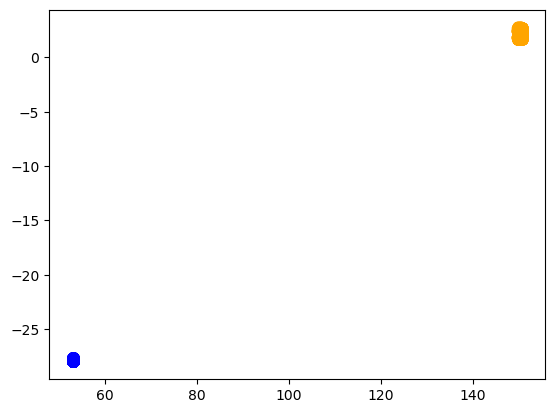

In [57]:
plt.scatter(aces['ra'],aces['dec'],color='blue')
#plt.scatter(vvds['ra'],vvds['dec'],color='red',s=0.5)
plt.scatter(zcosmos['ra'],zcosmos['dec'],color='orange')
#plt.xlim(51,54)
#plt.ylim(-30,-27)

## Selecting ACES AND COSMOS (?) cross-matched

```sql
SELECT * 
FROM des_dr2.public_pz_training_set 
WHERE survey = 'ZCOSMOS' OR survey = 'ACES'
```

In [58]:

query_matched = "SELECT * FROM des_dr2.public_pz_training_set WHERE survey = 'ZCOSMOS' OR survey = 'ACES'"




In [59]:
df_matched = db.fetchall_df(query_matched)

In [60]:


df_matched = df_matched[(df_matched['mag_auto_g_dered']<90) & (df_matched['mag_auto_r_dered']<90) &(df_matched['mag_auto_i_dered']<90) &(df_matched['mag_auto_z_dered']<90) &(df_matched['mag_auto_y_dered']<90)]




In [61]:


#df_matched = df_matched[(df_matched['magerr_auto_g']<0.103) & (df_matched['magerr_auto_r']<0.103) &(df_matched['magerr_auto_i']<0.103) &(df_matched['magerr_auto_z']<0.103) &(df_matched['magerr_auto_y']<0.103)]




In [62]:
df_matched.columns=['coadd_object_id','ra','dec','z','err_z','flag_des','survey','flag','mag_auto_g','mag_auto_r','mag_auto_i','mag_auto_z','mag_auto_y','magerr_auto_g','magerr_auto_r','magerr_auto_i','magerr_auto_z','magerr_auto_y']

In [63]:
zcosmos_matched = df_matched[df_matched['survey']=='ZCOSMOS']
aces_matched = df_matched[df_matched['survey']=='ACES']

## Main training sample

In [64]:
training_1 = vvds_snx3_matched.sample(int(len(vvds_snx3_matched)/2))
training_2 = sdss_matched.sample(int(len(sdss_matched)/2)) 
training_3 = aces_matched.sample(int(len(aces_matched)/2))
training_4 = two_d_matched.sample(int(len(two_d_matched)/2))
training_5 = ozdes_matched.sample(int(len(ozdes_matched)/2))

In [65]:
print(len(vvds_snx3_matched))
print(len(sdss_matched))
print(len(aces_matched))
print(len(two_d_matched))
print(len(ozdes_matched))

4302
739
3913
453
744


In [886]:
training = pd.concat([training_2,training_3,training_4,training_5,training_1],axis=0)

In [887]:
training

,alphawin_j2000,deltawin_j2000,ra,dec,extended_class_coadd,mag_auto_g,mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y,...,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y,z,survey,coadd_object_id,err_z,flag_des,flag
445303,37.288276,-4.068948,37.288276,-4.068948,3.0,21.948225,20.173151,19.536856,19.203068,19.095783,...,0.010336,0.010439,0.014997,0.031058,0.43707,SDSS/BOSS,NaN,NaN,NaN,NaN
335620,36.751350,-3.631129,36.751350,-3.631129,3.0,21.804007,19.900993,19.288082,18.925449,18.813053,...,0.007187,0.007576,0.009660,0.024429,0.43726,SDSS/BOSS,NaN,NaN,NaN,NaN
249356,35.681882,-3.984838,35.681882,-3.984838,3.0,21.539957,21.570257,21.732382,22.210974,28.075674,...,0.034032,0.069251,0.200825,122.913452,0.00770,SDSS/BOSS,NaN,NaN,NaN,NaN
309965,36.538492,-4.080699,36.538492,-4.080699,3.0,22.550037,20.699078,19.678026,19.244528,19.084986,...,0.017613,0.011650,0.015770,0.034693,0.62640,SDSS/BOSS,NaN,NaN,NaN,NaN
127132,36.571775,-5.372683,36.571775,-5.372683,3.0,17.089737,16.274050,15.904569,15.661888,15.550353,...,0.000596,0.000699,0.001042,0.002627,0.14878,SDSS/BOSS,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191277,36.671348,-4.750558,36.671348,-4.750558,3.0,21.598938,20.852461,20.455267,20.377773,20.472694,...,0.010386,0.012922,0.022916,0.064470,0.23640,VVDS-DEEP_SNX3,NaN,NaN,NaN,NaN
407761,36.920571,-4.627042,36.920571,-4.627042,2.0,23.965765,23.890997,23.374035,22.942709,23.284075,...,0.118226,0.124103,0.166778,0.573188,1.30030,VVDS-DEEP_SNX3,NaN,NaN,NaN,NaN
208992,36.591066,-4.329971,36.591066,-4.329971,3.0,24.510881,23.488411,22.933876,22.883371,22.921745,...,0.093863,0.107395,0.184193,0.503523,0.52360,VVDS-DEEP_SNX3,NaN,NaN,NaN,NaN
318685,36.800173,-4.066204,36.800173,-4.066204,3.0,29.870520,23.803967,22.568348,22.041485,21.713049,...,0.139440,0.078729,0.097166,0.162831,0.92790,VVDS-DEEP_SNX3,NaN,NaN,NaN,NaN


## Main testing sample

In [888]:
testing_1 = vvds_snx3_matched.drop(training_1.index)
testing_2 = sdss_matched.drop(training_2.index)
testing_3 = aces_matched.drop(training_3.index)
testing_4 = two_d_matched.drop(training_4.index)
testing_5 = ozdes_matched.drop(training_5.index)

In [889]:
testing = pd.concat([testing_2,testing_3,testing_4,testing_5,vvds_snc3_matched,testing_1],axis=0)

In [890]:
testing

,alphawin_j2000,deltawin_j2000,ra,dec,extended_class_coadd,mag_auto_g,mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y,...,magerr_auto_r,magerr_auto_i,magerr_auto_z,magerr_auto_y,z,survey,coadd_object_id,err_z,flag_des,flag
347081,37.255029,-5.688740,37.255029,-5.688740,3.0,22.149763,22.024118,21.480795,21.265371,21.381197,...,0.029117,0.031689,0.050407,0.187459,0.95767,SDSS/BOSS,NaN,NaN,NaN,NaN
347462,37.437240,-5.675342,37.437240,-5.675342,3.0,21.848080,20.027540,19.321104,18.867994,18.668270,...,0.009449,0.009188,0.012096,0.032901,0.48237,SDSS/BOSS,NaN,NaN,NaN,NaN
359507,37.413654,-5.640530,37.413654,-5.640530,3.0,17.227966,16.316692,15.940803,15.656432,15.529766,...,0.000828,0.001053,0.001519,0.004480,0.08701,SDSS/BOSS,NaN,NaN,NaN,NaN
359588,37.390743,-5.624734,37.390743,-5.624734,3.0,22.256493,21.933615,21.404972,21.240953,21.167528,...,0.023864,0.026510,0.043123,0.133044,0.98790,SDSS/BOSS,NaN,NaN,NaN,NaN
356864,37.219842,-5.677816,37.219842,-5.677816,3.0,20.389721,18.815584,18.272215,17.940228,17.810299,...,0.003106,0.003295,0.004647,0.013845,0.29940,SDSS/BOSS,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310028,36.529195,-4.051856,36.529195,-4.051856,3.0,23.970829,23.128885,22.021986,21.537502,21.554939,...,0.075660,0.047954,0.071392,0.168510,0.98390,VVDS-DEEP_SNX3,NaN,NaN,NaN,NaN
307954,36.429968,-4.059960,36.429968,-4.059960,2.0,25.257223,24.122269,23.884937,24.088453,24.437765,...,0.113406,0.150168,0.385409,1.324466,0.69130,VVDS-DEEP_SNX3,NaN,NaN,NaN,NaN
309374,36.438783,-4.057324,36.438783,-4.057324,3.0,24.702753,22.872892,22.202976,21.844450,21.811291,...,0.058558,0.052097,0.085259,0.198299,0.42780,VVDS-DEEP_SNX3,NaN,NaN,NaN,NaN
309401,36.447076,-4.049981,36.447076,-4.049981,3.0,23.412895,22.774393,22.617565,22.654896,23.331470,...,0.056495,0.087659,0.191226,0.822601,0.53940,VVDS-DEEP_SNX3,NaN,NaN,NaN,NaN


## Saving data

In [891]:
del testing['coadd_object_id'], testing['survey'], testing['err_z'], testing['flag'], testing['flag_des'], testing['ra'], testing['dec'], testing['alphawin_j2000'],testing['deltawin_j2000'],testing['extended_class_coadd']
del training['coadd_object_id'], training['survey'], training['err_z'], training['flag'], training['flag_des'], training['ra'], training['dec'], training['alphawin_j2000'],training['deltawin_j2000'],training['extended_class_coadd']


In [892]:
last_column = training.columns[-1]
training = training[[last_column] + [column for column in training.columns if column != last_column]]

last_column2 = testing.columns[-1]
testing = testing[[last_column2] + [column for column in training.columns if column != last_column2]]

In [893]:
g = testing['mag_auto_g']
r = testing['mag_auto_r']
i = testing['mag_auto_i']
z = testing['mag_auto_z']
y = testing['mag_auto_y']
gt = training['mag_auto_g']
rt = training['mag_auto_r']
it = training['mag_auto_i']
zt = training['mag_auto_z']
yt = training['mag_auto_y']

testing['g-r'] = g-r
testing['r-i'] = r-i
testing['i-z'] = i-z
testing['z-y'] = z-y
training['g-r'] = gt-rt
training['r-i'] = rt-it
training['i-z'] = it-zt
training['z-y'] = zt-yt

In [894]:
testing.columns = ['#zs','g','r','i','z','y','eg','er','ei','ez','ey','g-r','r-i','i-z','z-y']
training.columns = ['#zs','g','r','i','z','y','eg','er','ei','ez','ey','g-r','r-i','i-z','z-y']

In [895]:
testing['eg-r'] = testing['eg']-testing['er']
testing['er-i'] = testing['er']-testing['ei']
testing['ei-z'] = testing['ei']-testing['ez']
testing['ez-y'] = testing['ez']-testing['ey']
training['eg-r'] = training['eg']-training['er']
training['er-i'] = training['er']-training['ei']
training['ei-z'] = training['ei']-training['ez']
training['ez-y'] = training['ez']-training['ey']

In [897]:
testing.to_csv('/home/iago.dias/Plots-TPZ/iago/ml_analyses/validation.sanchez2', sep=' ', index = False)
training.to_csv('/home/iago.dias/Plots-TPZ/iago/ml_analyses/training.sanchez2', sep=' ', index = False)

In [896]:
training

,#zs,g,r,i,z,y,eg,er,ei,ez,ey,g-r,r-i,i-z,z-y,eg-r,er-i,ei-z,ez-y
445303,0.43707,21.948225,20.173151,19.536856,19.203068,19.095783,0.042455,0.010336,0.010439,0.014997,0.031058,1.775074,0.636295,0.333788,0.107285,0.032118,-0.000103,-0.004558,-0.016061
335620,0.43726,21.804007,19.900993,19.288082,18.925449,18.813053,0.035348,0.007187,0.007576,0.009660,0.024429,1.903013,0.612911,0.362633,0.112396,0.028161,-0.000389,-0.002085,-0.014769
249356,0.00770,21.539957,21.570257,21.732382,22.210974,28.075674,0.027527,0.034032,0.069251,0.200825,122.913452,-0.030300,-0.162125,-0.478592,-5.864700,-0.006505,-0.035219,-0.131574,-122.712627
309965,0.62640,22.550037,20.699078,19.678026,19.244528,19.084986,0.073320,0.017613,0.011650,0.015770,0.034693,1.850960,1.021051,0.433498,0.159542,0.055707,0.005963,-0.004120,-0.018923
127132,0.14878,17.089737,16.274050,15.904569,15.661888,15.550353,0.000906,0.000596,0.000699,0.001042,0.002627,0.815687,0.369481,0.242681,0.111535,0.000310,-0.000103,-0.000344,-0.001585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191277,0.23640,21.598938,20.852461,20.455267,20.377773,20.472694,0.015645,0.010386,0.012922,0.022916,0.064470,0.746477,0.397194,0.077494,-0.094921,0.005260,-0.002536,-0.009994,-0.041554
407761,1.30030,23.965765,23.890997,23.374035,22.942709,23.284075,0.086040,0.118226,0.124103,0.166778,0.573188,0.074768,0.516962,0.431326,-0.341366,-0.032187,-0.005877,-0.042675,-0.406411
208992,0.52360,24.510881,23.488411,22.933876,22.883371,22.921745,0.203067,0.093863,0.107395,0.184193,0.503523,1.022470,0.554535,0.050505,-0.038374,0.109205,-0.013532,-0.076799,-0.319330
318685,0.92790,29.870520,23.803967,22.568348,22.041485,21.713049,28.181671,0.139440,0.078729,0.097166,0.162831,6.066553,1.235619,0.526863,0.328436,28.042231,0.060712,-0.018437,-0.065665


## Looking plots

In [301]:
vvds_deep_matched = pd.concat([vvds_snc3_matched,vvds_snx3_matched],axis=0)

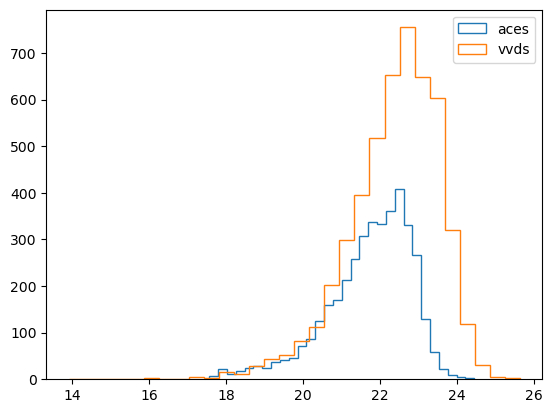

In [306]:
f = plt.hist(aces_matched['mag_auto_i'],histtype='step',bins=30, label = 'aces')
f = plt.hist(vvds_deep_matched['mag_auto_i'],histtype='step',bins=30, label='vvds')
plt.legend()

In [298]:
main = pd.concat([testing,training],axis=0)

In [299]:
main = main[main['#zs']<1.4]

In [297]:
max(main['#zs'])

6.83438

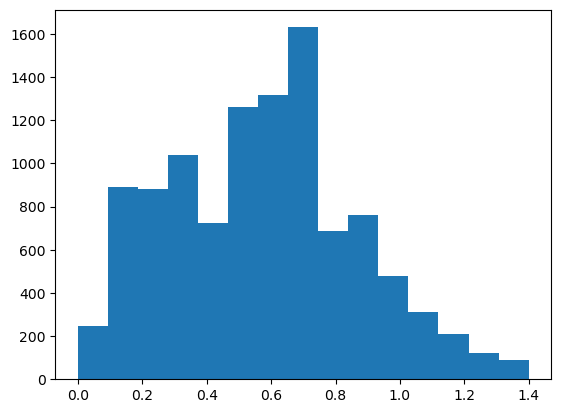

In [300]:
r = plt.hist(main['#zs'], bins = 15)

## Results analyses

In [627]:

column_names = ['ztrue','zmode0','zmean1','zConf0','zConf1','err0','err1']
df = pd.read_csv('/home/iago.dias/Plots-TPZ/iago/ml_analyses/results/results.sanchez2.0.mlz',names = column_names, header = None, skiprows =1, sep =' ')

zspec=df['ztrue']
zphot = df['zmean1']


In [78]:
# Calcula a estimativa de densidade usando kernel
kde = gaussian_kde([zspec, zphot])

# Define os limites do gráfico
x_min, x_max = min(zspec), max(zspec)
y_min, y_max = min(zphot), max(zphot)


In [79]:
# Cria uma grade de valores para o gráfico
x, y = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
z = kde(np.vstack([x.ravel(), y.ravel()]))


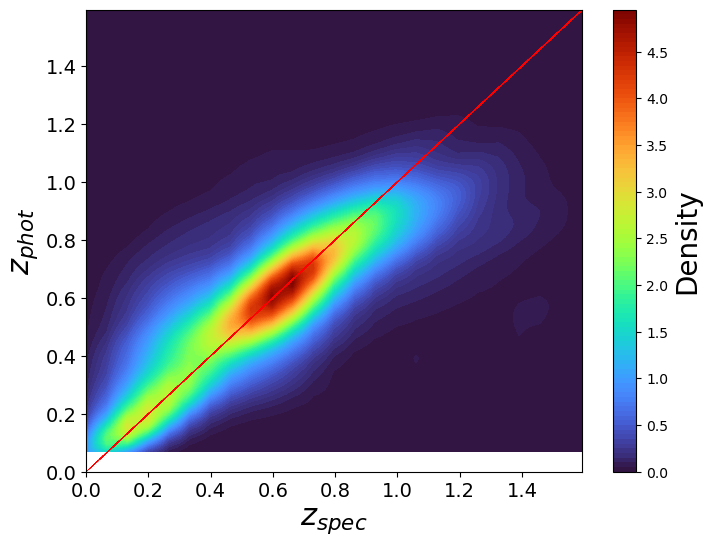

In [80]:
plt.figure(figsize=(8,6))



plt.plot(zspec,zspec,'r--', linewidth =0.5)


plt.contourf(x, y, z.reshape(x.shape), cmap='turbo', levels=100)
colorbar = plt.colorbar()
colorbar.set_label('Density', fontsize=20)

plt.xlim(0, max(zphot))
plt.ylim(0, max(zphot))

plt.xlabel(r'$z_{spec}$', fontsize=22)
plt.ylabel(r'$z_{phot}$',fontsize=22)

plt.xticks(fontsize=14)  # Tamanho da fonte nos números do eixo x
plt.yticks(fontsize=14)


plt.show()


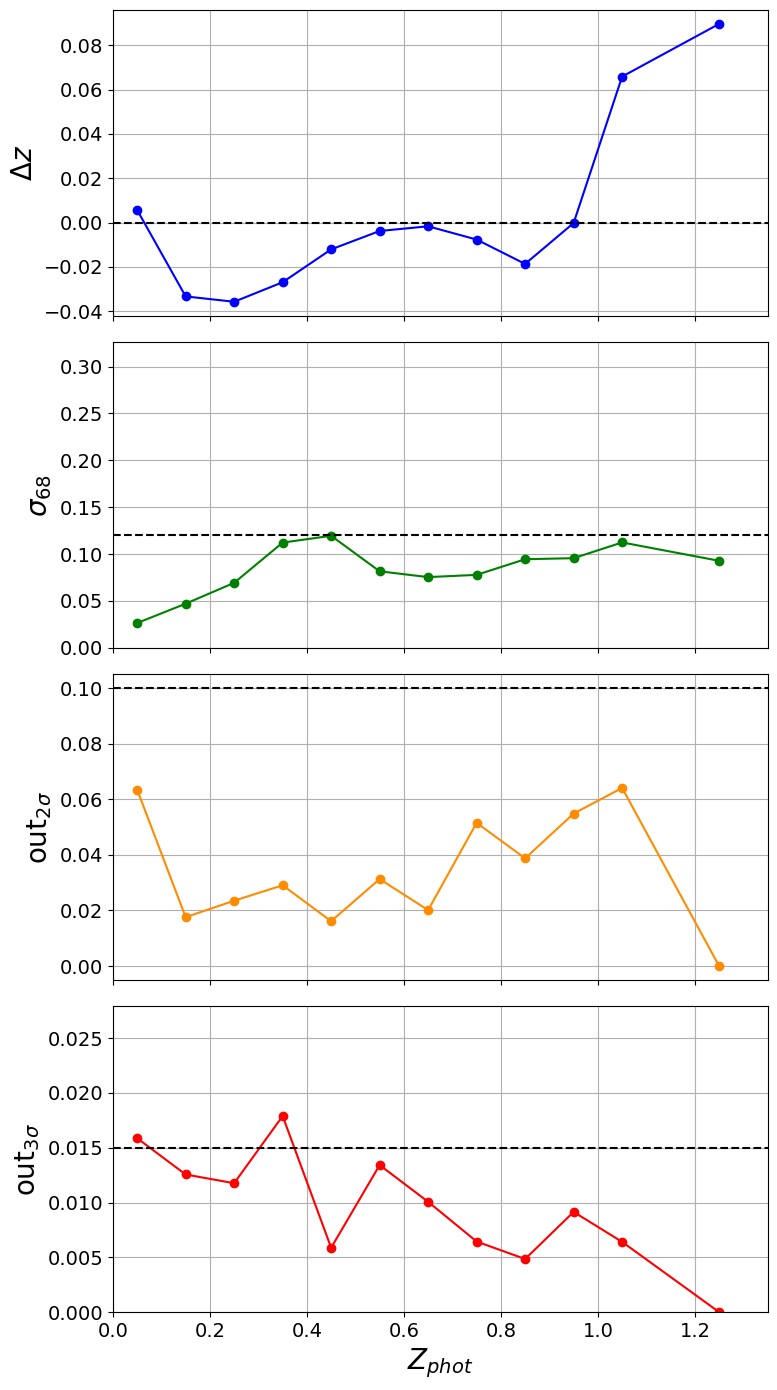

In [105]:
bins = np.array([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.2,1.3])
points = bins+0.05
fraction_outliers = []
sigma68z = []
sigmaz=[]
meanz = []
outliers_2 = []

for index in range(len(bins) - 1):
    bin_lower = bins[index]
    bin_upper = bins[index + 1]
    
    values_r = zphot[(zphot >= bin_lower) & (zphot <= bin_upper)]
    values_s = zspec[(zphot >= bin_lower) & (zphot <= bin_upper)]

    deltabias = (values_r - values_s)
    mean_bias = np.mean(deltabias)  # Mean bias for each bin
    meanz.append(mean_bias)
    
    s = np.sort(np.abs(deltabias/(1+values_s)))  # Standard deviation (sigma) for each bin
    sigma68 = s[int(len(s)*0.68)]
    sigma68z.append(sigma68)

    sigma = (np.sum((values_r-values_s-mean_bias)**2)/len(values_r))**0.5
    sigmaz.append(sigma)
    
    # Calculate the fraction of outliers outside 3 sigma
    outliers = deltabias[np.abs(deltabias-mean_bias) > 3 * sigma]
    fraction_outlier = len(outliers) / len(deltabias)
    
    fraction_outliers.append(fraction_outlier)
    
    #2 sigma
    outliers2 = deltabias[np.abs(deltabias-mean_bias) > 2 * sigma]
    fraction_outlier2 = len(outliers2) / len(deltabias)
    
    
    outliers_2.append(fraction_outlier2)



fig, axes = plt.subplots(4, 1, figsize=(8, 14), sharex=True)
plt.subplots_adjust(hspace=0.001)  # Ajuste o espaço entre os subplots

# Configure os limites x comuns para todos os subplots
x_lim = (0, np.max(zphot))

# Subplot 1: Mean Bias
axes[0].plot(points[:-1], meanz, 'bo-')
axes[0].axhline(0, color='black', linestyle='--')
axes[0].set_ylabel(r'$\Delta z$', fontsize=20)
axes[0].set_xlim(x_lim)
axes[0].tick_params(axis='both', labelsize=14)
axes[0].grid(True)

# Subplot 2: Standard Deviation
axes[1].plot(points[:-1], sigma68z, 'go-')
axes[1].set_ylabel(r'$\sigma_{68}$', fontsize=20)
axes[1].set_xlim(x_lim)
axes[1].axhline(0.12, color='black', linestyle='--')
axes[1].set_ylim(0,max(sigmaz)+0.01)
axes[1].tick_params(axis='both', labelsize=14)
axes[1].grid(True)


# Subplot3: outlier
axes[2].plot(points[:-1],outliers_2,'o-',color='darkorange')
#axes[2].set_xlabel(r'$Z_{phot}$', fontsize=20)
axes[2].set_ylabel('out$_{2σ}$', fontsize=20)
axes[2].set_xlim(x_lim)
#axes[2].set_ylim(0,max(outliers_2)+0.01)
axes[2].axhline(0.1, color='black', linestyle='--')
axes[2].tick_params(axis='both', labelsize=14)
axes[2].grid(True)
axes[2].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# Subplot 4: Outliers
axes[3].plot(points[:-1], fraction_outliers, 'ro-')
axes[3].set_xlabel(r'$Z_{phot}$', fontsize=20)
axes[3].set_ylabel('out$_{3σ}$', fontsize=20)
axes[3].set_xlim(x_lim)
axes[3].set_ylim(0,max(fraction_outliers)+0.01)
axes[3].axhline(0.015, color='black', linestyle='--')
axes[3].tick_params(axis='both', labelsize=14)
axes[3].grid(True)


plt.xlim(0,points[-1])
# Ajuste o layout dos subplots
plt.tight_layout()


# Exiba a figura
plt.show()


In [98]:
meanz = np.mean(zphot-zspec)
sigmaz = (np.sum((zphot-zspec-meanz)**2)/len(zphot))**0.5
s = np.sort(np.abs((zphot-zspec)/(1+zspec)))
sigmaz68 = s[int(len(s)*0.68)]
fraction3 = len(zphot[np.abs((zphot-zspec-meanz))>3*sigmaz])/len(zphot)
fraction2 = len(zphot[np.abs(zphot-zspec-meanz)>2*sigmaz])/len(zphot)

In [99]:
print(f'Mean z:{meanz}')
print(f'Sigma z:{sigmaz}')
print(f'Sigma68 z:{sigmaz68}')
print(f'Out_3 z:{fraction3}')
print(f'Out_2 z:{fraction2}')

Mean z:-0.00991962715441435
Sigma z:0.24733857407772927
Sigma68 z:0.08574866017718476
Out_3 z:0.01020049243756595
Out_2 z:0.028666901160745693


## Weighting

```sql
SELECT erra_image, ra, dec, extended_class_coadd, mag_auto_g, mag_auto_r, mag_auto_i, mag_auto_z, mag_auto_y, magerr_auto_g, magerr_auto_r, magerr_auto_i, magerr_auto_z, magerr_auto_y 
FROM des_dr2.coadd_objects 
WHERE extended_class_coadd>=2 AND flags_g<4 AND flags_r<4 AND flags_i<4 AND flags_z<4 AND flags_y<4 ORDER BY RANDOM() LIMIT 10000;

```

In [71]:


query_dr2 = "SELECT erra_image, ra, dec, extended_class_coadd, mag_auto_g, mag_auto_r, mag_auto_i, mag_auto_z, mag_auto_y, magerr_auto_g, magerr_auto_r, magerr_auto_i, magerr_auto_z, magerr_auto_y FROM des_dr2.coadd_objects WHERE extended_class_coadd>=2 AND flags_g<4 AND flags_r<4 AND flags_i<4 AND flags_z<4 AND flags_y<4 ORDER BY RANDOM() LIMIT 10000;"



In [72]:
%%time
origin = db.fetchall_df(query_dr2)
dr2_sample = origin

CPU times: user 218 ms, sys: 33.5 ms, total: 251 ms
Wall time: 28min 54s


In [833]:
def weighting(n_near,phot,trai):
    
    #train = train[((train['mag_auto_g']-train['mag_auto_r'])<2) & ((train['mag_auto_g']-train['mag_auto_r'])>0) & ((train['mag_auto_r']-train['mag_auto_i'])<2) & ((train['mag_auto_r']-train['mag_auto_i'])>0) & (train['mag_auto_i']<24) & (train['mag_auto_i']>18)]

    trai['weight']=0.0
    vector_phot = np.array([phot['mag_auto_g'],phot['mag_auto_r'],phot['mag_auto_i'],phot['mag_auto_z'],phot['mag_auto_y']])
    vector_phot = vector_phot.T
    vector_trai = np.array([trai['mag_auto_g'],trai['mag_auto_r'],trai['mag_auto_i'],trai['mag_auto_z'],trai['mag_auto_y']])
    vector_trai = vector_train.T

    for galaxy in tqdm(range(len(vector_trai))):
        diff = vector_trai-vector_trai[galaxy]
        dist = np.sum(diff**2, axis=1)
        
        
        nearest = np.argsort(dist)[:n_near]
        max_dist = max(dist[nearest])
        
        top = vector_trai[galaxy] + np.sqrt(max_dist/5)
        bottom = vector_trai[galaxy] - np.sqrt(max_dist/5)
        
        n_phot = len(vector_phot[(vector_phot<top)& (vector_phot>bottom)])
        weight = n_phot/(n_near*len(phot))
        
        trai.at[trai.index[galaxy], 'weight']=weight
    return trai

In [840]:
def recalculation(n_near,phot,train,w_min):
    modified_w = []
    low_w = train[train['weight']>w_min]
    
    vector_phot = np.array([phot['mag_auto_g'],phot['mag_auto_r'],phot['mag_auto_i'],phot['mag_auto_z'],phot['mag_auto_y']])
    vector_phot = vector_phot.T
    vector_train = np.array([low_w['mag_auto_g'],low_w['mag_auto_r'],low_w['mag_auto_i'],low_w['mag_auto_z'],low_w['mag_auto_y']])
    vector_train = vector_train.T
    
    for galaxy in tqdm(range(len(vector_train))):
        diff = vector_train-vector_train[galaxy]
        dist = np.sum(diff**2, axis=1)
        
        nearest = np.argsort(dist)[:n_near]
        max_dist = max(dist[nearest])
        
        top = vector_train[galaxy] + np.sqrt(max_dist/5)
        bottom = vector_train[galaxy] - np.sqrt(max_dist/5)
        
        n_phot = len(vector_phot[(vector_phot<top)& (vector_phot>bottom)])
        weight = n_phot/(n_near*len(phot))
        
        train.at[train.index[galaxy], 'weight']=weight
    
        
    return train

In [ ]:



#testing_w = testing[((testing['mag_auto_g']-testing['mag_auto_r'])<2) & ((testing['mag_auto_g']-testing['mag_auto_r'])>0) & ((testing['mag_auto_r']-testing['mag_auto_i'])<2) & ((testing['mag_auto_r']-testing['mag_auto_i'])>0) & (testing['mag_auto_i']<24) & (testing['mag_auto_i']>18)]





In [866]:
testing

,alphawin_j2000,deltawin_j2000,ra,dec,extended_class_coadd,mag_auto_g,mag_auto_r,mag_auto_i,mag_auto_z,mag_auto_y,...,magerr_auto_i,magerr_auto_z,magerr_auto_y,z,survey,coadd_object_id,err_z,flag_des,flag,weight
347081,37.255029,-5.688740,37.255029,-5.688740,3.0,22.149763,22.024118,21.480795,21.265371,21.381197,...,0.031689,0.050407,0.187459,0.95767,SDSS/BOSS,NaN,NaN,NaN,NaN,0.173914
347462,37.437240,-5.675342,37.437240,-5.675342,3.0,21.848080,20.027540,19.321104,18.867994,18.668270,...,0.009188,0.012096,0.032901,0.48237,SDSS/BOSS,NaN,NaN,NaN,NaN,0.118286
359507,37.413654,-5.640530,37.413654,-5.640530,3.0,17.227966,16.316692,15.940803,15.656432,15.529766,...,0.001053,0.001519,0.004480,0.08701,SDSS/BOSS,NaN,NaN,NaN,NaN,0.093529
359588,37.390743,-5.624734,37.390743,-5.624734,3.0,22.256493,21.933615,21.404972,21.240953,21.167528,...,0.026510,0.043123,0.133044,0.98790,SDSS/BOSS,NaN,NaN,NaN,NaN,0.127671
356864,37.219842,-5.677816,37.219842,-5.677816,3.0,20.389721,18.815584,18.272215,17.940228,17.810299,...,0.003295,0.004647,0.013845,0.29940,SDSS/BOSS,NaN,NaN,NaN,NaN,0.102600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310028,36.529195,-4.051856,36.529195,-4.051856,3.0,23.970829,23.128885,22.021986,21.537502,21.554939,...,0.047954,0.071392,0.168510,0.98390,VVDS-DEEP_SNX3,NaN,NaN,NaN,NaN,0.002831
307954,36.429968,-4.059960,36.429968,-4.059960,2.0,25.257223,24.122269,23.884937,24.088453,24.437765,...,0.150168,0.385409,1.324466,0.69130,VVDS-DEEP_SNX3,NaN,NaN,NaN,NaN,0.009369
309374,36.438783,-4.057324,36.438783,-4.057324,3.0,24.702753,22.872892,22.202976,21.844450,21.811291,...,0.052097,0.085259,0.198299,0.42780,VVDS-DEEP_SNX3,NaN,NaN,NaN,NaN,0.003947
309401,36.447076,-4.049981,36.447076,-4.049981,3.0,23.412895,22.774393,22.617565,22.654896,23.331470,...,0.087659,0.191226,0.822601,0.53940,VVDS-DEEP_SNX3,NaN,NaN,NaN,NaN,0.003536


In [885]:
g = np.array(testing['z'])
for i in range(10):
    print(f"{zspec[i]} and {g[i]}")

0.9577 and 0.95767
0.3387 and 0.48237
0.4824 and 0.08701
0.9879 and 0.9879
0.2994 and 0.2994
0.3375 and 0.44146
0.6232 and 0.38379
0.1929 and 0.34732
0.2988 and 0.2988
0.7862 and 0.50117


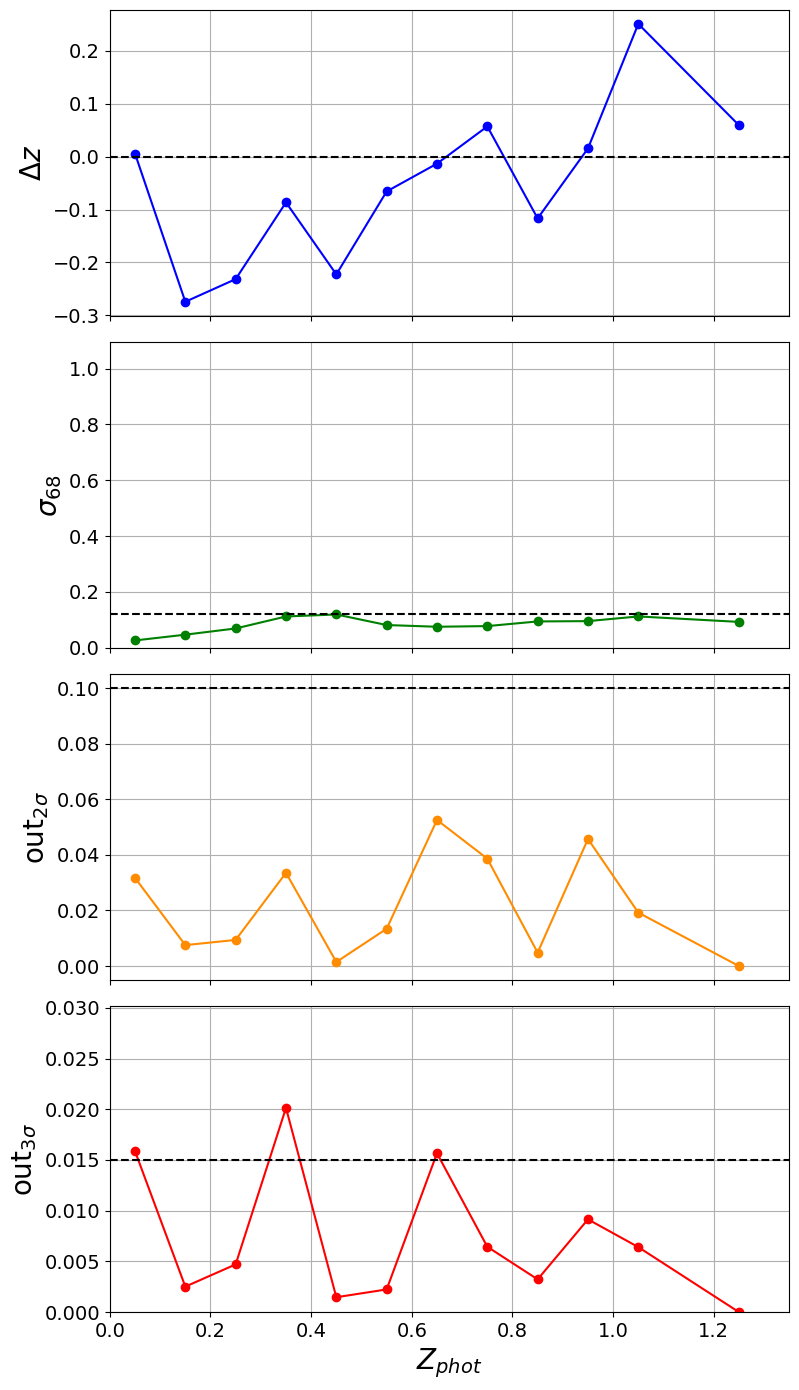

In [863]:
bins = np.array([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.2,1.3])
points = bins+0.05
fraction_outliers = []
sigma68z = []
sigmaz=[]
meanz = []
outliers_2 = []
w = np.array(testing['weight'])


for index in range(len(bins) - 1):
    bin_lower = bins[index]
    bin_upper = bins[index + 1]
    
    values_r = zphot[(zphot >= bin_lower) & (zphot <= bin_upper)]
    values_s = zspec[(zphot >= bin_lower) & (zphot <= bin_upper)]
    w_bin = w[(zphot >= bin_lower) & (zphot <= bin_upper)]

    deltabias = (values_r - values_s)
    mean_bias = np.sum(w_bin*deltabias)/np.sum(w_bin)  # Mean bias for each bin
    meanz.append(mean_bias)
    
    s = np.sort(np.abs(deltabias/(1+values_s)))  # Standard deviation (sigma) for each bin
    sigma68 = s[int(len(s)*0.68)]
    sigma68z.append(sigma68)

    sigma = (np.sum(w_bin*(values_r-values_s-mean_bias)**2)/np.sum(w_bin))**0.5
    sigmaz.append(sigma)
    
    # Calculate the fraction of outliers outside 3 sigma
    outliers = deltabias[np.abs(deltabias-mean_bias) > 3 * sigma]
    fraction_outlier = len(outliers) / len(deltabias)
    
    fraction_outliers.append(fraction_outlier)
    
    #2 sigma
    outliers2 = deltabias[np.abs(deltabias-mean_bias) > 2 * sigma]
    fraction_outlier2 = len(outliers2) / len(deltabias)
    
    
    outliers_2.append(fraction_outlier2)



fig, axes = plt.subplots(4, 1, figsize=(8, 14), sharex=True)
plt.subplots_adjust(hspace=0.001)  # Ajuste o espaço entre os subplots

# Configure os limites x comuns para todos os subplots
x_lim = (0, np.max(zphot))

# Subplot 1: Mean Bias
axes[0].plot(points[:-1], meanz, 'bo-')
axes[0].axhline(0, color='black', linestyle='--')
axes[0].set_ylabel(r'$\Delta z$', fontsize=20)
axes[0].set_xlim(x_lim)
axes[0].tick_params(axis='both', labelsize=14)
axes[0].grid(True)

# Subplot 2: Standard Deviation
axes[1].plot(points[:-1], sigma68z, 'go-')
axes[1].set_ylabel(r'$\sigma_{68}$', fontsize=20)
axes[1].set_xlim(x_lim)
axes[1].axhline(0.12, color='black', linestyle='--')
axes[1].set_ylim(0,max(sigmaz)+0.01)
axes[1].tick_params(axis='both', labelsize=14)
axes[1].grid(True)


# Subplot3: outlier
axes[2].plot(points[:-1],outliers_2,'o-',color='darkorange')
#axes[2].set_xlabel(r'$Z_{phot}$', fontsize=20)
axes[2].set_ylabel('out$_{2σ}$', fontsize=20)
axes[2].set_xlim(x_lim)
#axes[2].set_ylim(0,max(outliers_2)+0.01)
axes[2].axhline(0.1, color='black', linestyle='--')
axes[2].tick_params(axis='both', labelsize=14)
axes[2].grid(True)
axes[2].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# Subplot 4: Outliers
axes[3].plot(points[:-1], fraction_outliers, 'ro-')
axes[3].set_xlabel(r'$Z_{phot}$', fontsize=20)
axes[3].set_ylabel('out$_{3σ}$', fontsize=20)
axes[3].set_xlim(x_lim)
axes[3].set_ylim(0,max(fraction_outliers)+0.01)
axes[3].axhline(0.015, color='black', linestyle='--')
axes[3].tick_params(axis='both', labelsize=14)
axes[3].grid(True)


plt.xlim(0,points[-1])
# Ajuste o layout dos subplots
plt.tight_layout()


# Exiba a figura
plt.show()


In [189]:
meanz = np.sum(w*(zphot-zspec))/np.sum(w)
sigmaz = (np.sum(w*(zphot-zspec-meanz)**2)/np.sum(w))**0.5
s = np.sort(np.abs((zphot-zspec)/(1+zspec)))
sigmaz68 = s[int(len(s)*0.68)]
fraction3 = len(zphot[np.abs((zphot-zspec-meanz))>3*sigmaz])/len(zphot)
fraction2 = len(zphot[np.abs(zphot-zspec-meanz)>2*sigmaz])/len(zphot)

In [190]:
print(f'Mean z:{meanz}')
print(f'Sigma z:{sigmaz}')
print(f'Sigma68 z:{sigmaz68}')
print(f'Out_3 z:{fraction3}')
print(f'Out_2 z:{fraction2}')

Mean z:-0.008634292335081823
Sigma z:0.2600184599326454
Sigma68 z:0.08574866017718476
Out_3 z:0.009848751319029195
Out_2 z:0.024973619416109743


In [696]:
%%time

w = weighting(180,dr2_sample,testing)

  0%|          | 0/2 [00:00<?, ?it/s]


IndexError: index 2 is out of bounds for axis 0 with size 2

In [687]:
testing = testing.sort_index()
testing['w']=w

In [688]:
new_w = recalculation(7,dr2_sample,testing,0.01)
w = new_w['w']
new_w.reset_index(drop=True, inplace=True)
testing.reset_index(drop=True, inplace=True)
testing = pd.concat([testing, new_w], axis=1)

100%|██████████| 132/132 [00:00<00:00, 1449.61it/s]
/tmp/ipykernel_13157/3875021599.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_w['w']=modified_w


In [624]:
te = dr2_sample[dr2_sample['mag_auto_g']<99]

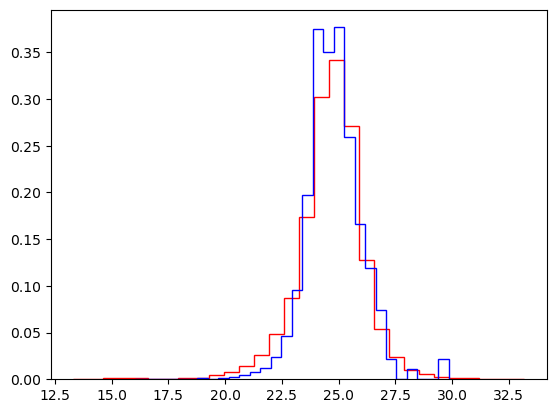

In [625]:
g = plt.hist(te['mag_auto_g'],bins=30, density=True, color='red',histtype='step')
#j = plt.hist(testing['mag_auto_g'],bins=30,density = True,color='green',weights=w,histtype='step')
k = plt.hist(new_w['mag_auto_g'],bins=30,density = True,color='blue',weights=new_w['w'],histtype='step')
